# Modelling Player Strategy in Monopoly
### by Tiarnán Curran-Feeney
***

## Introduction:
<br>

Monopoly is a strategy game requiring people to take risks in the form of investments for the chance to earn money later in the game. This raises the question is there an optimum level of 'riskiness' for success? Secondly, does the optimum level of riskiness depend on the riskiness of your opponents?

The following implementation will allow us to test how the riskiness of your opponents alters the outcome of the game. To observe the model, please see section 3.3 of the writeup.

## Simulating Player Strategy:

Each player will have two choices per turn. The first choice before they roll their dice is will they buy a house for one of their streets and the second choice after they roll their dice is, if the street they land on is available to purchase, will they purchase the street. In our model we shall represent this choice by having two probabilities p and q, where a player will purchase a house each turn with probability q and a player will purchase a street they land on with probability p. To simulate player strategy these parameters p and q will depend on the current state of the game.

We want to create a Rule Based System that will update at the start of a player's turn that will update their values for p and q. This will allow for us to increase a player's risk when they have a lot of money or the cost of rent on the board is low for them. Similarly, this will allow us to increase a player's risk when the reverse is true. We end up with the model shown below. This is covered in more detail in the write up.

__Definitions:__
<br>

|Variable | Meaning                                             |
|---------|-----------------------------------------------------|
|$R_i$:   | Riskiness of Player i                               |
|$A_i$:   | Anxiousness of Player i                             |
|$W_i$:   | Player i's value of money                           |
|$M_i$:   | Amount of Money Player i has                        |
|$C_i$:   | Sum of All Rent on Board Payable by Player i        |
|$R_i^L$: | Lower Bound on Player i's Riskiness                 |
|$R_i^U$: | Upper Bound on Player i's Riskiness                 |

__Reactions:__
<br>
$$
\begin{align}
    \alpha_i &= Max(\frac{M_i-W_iC_i}{M_i + W_iC_i},0) &i \in [4]\\
    \beta_i &= 1 - \alpha_i &i \in [4]\\
    [R_i',A_i'] &= [R_i - R_i^L,A_i - (1-R_i^U)], &i \in [4]\\
    A_i' &\mathrel{\mathop{\rightleftarrows}^{\mathrm{\alpha_i}}_{\mathrm{\beta_i}}} R_i', &i \in [4]\\
    A_i' + R_j + R_k &\mathrel{\mathop{\rightarrow}^{\mathrm{\gamma_i^1}}} R_i' + R_j + R_k, &i \neq j \neq k \in [4]\\
    R_i' + A_j + A_k &\mathrel{\mathop{\rightarrow}^{\mathrm{\gamma_i^2}}} A_i' + A_j + A_k, &i \neq j \neq k \in [4]
\end{align}
$$

## Implementation

First load some libraries:

In [347]:
import random
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from operator import add
from statistics import mean

### The Board:

Now we will define the board class which will be used to play the game. The board will be able to communicate with players while decisions, such as purchases, will be made by the individual players themselves.

In [348]:
class board(object):
    def __init__(self,players):
        self.playCount = len(players)
        self.players = players
        #[0,x] - advance to x,[1,x] - pay x, [2,x] - get paid x, [3,x] - get out of jail/go to jail, [4,x] - go forward x spaces, [5,x,y] - street repairs x on houses, y on hotels, [6,x] - collect x from each player
        self.chance = [[0,0],[0,39],[0,11],[0,15],[0,24],[1,150],[1,15],[1,20],[2,150],[2,100],[2,50],[3,0],[3,1],[4,-3],[5,25,100],[5,40,115]]
        self.chest = [[0,0],[2,200],[1,50],[1,45],[3,0],[3,1],[6,10],[1,20],[2,10],[2,100],[1,100],[1,150],[5,40,115],[2,25],[2,20],[2,100]]
        #[ownership, cost, set, # in set, developable?, [#houses,cost of houses],[rent prices]]
        self.currentPlayer = 0
        self.playerPos = [0] * self.playCount
        self.stats = {}
        
    def gameState(self):
        return [self.board,self.playerPos] #returns the board info

    def posState(self,pos): #returns the board info for that position
        return self.board[pos]
    
    def devPlots(self): #returns plots player can develop
        #list of all plots the player owns
        plots, nonplots = self.plots(self.currentPlayer)
        
        #plotInfo stores the number of properties in each set
        plotInfo = [[2,[]],[3,[]],[3,[]],[3,[]],[3,[]],[3,[]],[3,[]],[3,[]],[4,[]],[2,[]]]
        for plot in plots: #Now we add which plots the player has in that set
            plotInfo[self.board[plot][2]][1].append(plot)
        
        #Removing stations and companies as they can't be developed
        plotInfo.pop(9)
        plotInfo.pop(8)
        
        #Plots will be the list of plots we can develop
        plots = []
        for colour in plotInfo:
            #Checking if the player owns full set
            if colour[0] == len(colour[1]):
                
                for plot in colour[1]:
                    #plot is not developable if it owns a hotel e.g: if self.board[plot][5][0] == 6
                    if self.board[plot][5][0] == 6:
                        colour[1].delete(plot) #plot is removed           
                        
                    if colour[1] != []: #If at least one plot developable then set added to developalbe plots
                        colour[0] = self.board[colour[1][0]][5][1]
                        plots.append(colour)
        return plots
    
    def plots(self,playerNo):
        #partitioning properties into those the player owns and those the player doesn't
        plots = []
        nonplots = []
        for plot in range(len(self.board)):
            if self.board[plot][0] == playerNo:
                plots.append(plot)
            elif self.board[plot][0] >= 0:
                nonplots.append(plot)
        
        return plots, nonplots
    
    def startGame(self,maxRolls):
        #Resetting the board
        self.board = [[-2,0],[-1,60,0,2,1,[0,50],[2,4,10,30,90,160,250]],[-2,-2],[-1,60,0,2,1,[0,50],[4,8,20,60,180,320,450]],[-2,1,200],[-1,200,8,4,[0]*self.playCount,[25,50,100,200]],[-1,100,1,3,1,[0,50],[6,12,30,90,270,400,550]],[-2,-1],[-1,100,1,3,1,[0,50],[6,12,30,90,270,400,550]],[-1,120,1,3,1,[0,50],[8,16,40,100,300,450,600]],
                      [-2,0],[-1,140,2,3,1,[0,70],[10,20,50,150,450,625,750]],[-1,150,9,2,[0]*self.playCount],[-1,140,2,3,1,[0,70],[10,20,50,150,450,625,750]],[-1,160,2,3,1,[0,70],[12,24,60,180,500,700,900]],[-1,200,8,4,[0]*self.playCount,[25,50,100,200]],[-1,180,3,3,1,[0,100],[14,28,70,200,550,750,950]],[-2,[]],[-1,180,3,3,1,[0,100],[14,28,70,200,550,750,950]],[-1,200,3,3,1,[0,100],[16,32,80,220,600,800,1000]],
                      [-2,1,0],[-1,220,4,3,1,[0,110],[18,36,90,250,700,875,1050]],[-2,[]],[-1,220,4,3,1,[0,110],[18,36,90,250,700,875,1050]],[-1,240,4,3,1,[0,110],[20,40,100,300,750,925,1100]],[-1,200,8,4,[0]*self.playCount,[25,50,100,200]],[-1,260,5,3,1,[0,150],[22,44,110,330,800,975,1150]],[-1,260,5,3,1,[0,150],[22,44,110,330,800,975,1150]],[-1,150,9,2,[0]*self.playCount],[-1,280,5,3,1,[0,150],[24,48,120,360,850,1025,1200]],
                      [-2,[]],[-1,300,6,3,1,[0,200],[26,52,130,390,900,1100,1275]],[-1,300,6,3,1,[0,200],[26,52,130,390,900,1100,1275]],[-2,[]],[-1,320,6,3,1,[0,200],[28,56,150,450,1000,1200,1400]],[-1,200,8,4,[0]*self.playCount,[25,50,100,200]],[-2,[]],[-1,350,7,2,1,[0,200],[35,70,175,500,1100,1300,1500]],[-2,[]],[-1,400,7,2,1,[0,200],[50,200,600,1400,1700,2000]]
                      ]
        #Defining the gamelength, player position vector, and picking the current player
        gameLength = maxRolls * self.playCount
        self.playerPos = [0] * self.playCount
        self.currentPlayer = random.randint(0,self.playCount - 1)
        
        #Shuffling chest cards, chance cards and number of turns
        noRolls = 0
        draw = True
        random.shuffle(self.chance)
        random.shuffle(self.chest)
        
        #Notifying all players to reset their stats for a new game
        for i in range(len(self.players)):
            self.players[i].newGame(i,self)
        
        while noRolls < gameLength:
            #If a player is playing they make their move
            if self.players[self.currentPlayer].playing() >= 1:
                self.playerPos[self.currentPlayer] = self.players[self.currentPlayer].move(self.playerPos[self.currentPlayer])
            
            #Updating current player
            self.currentPlayer = (self.currentPlayer + 1) % self.playCount
            noRolls += 1
            
            #Checking how many players are still playing
            endGame = 0
            for player in self.players:
                endGame += player.playing()
            if endGame < 2: #If less than two playing then game ends
                draw = False
                break
            
        #Announcing game over and telling players if they won or not
        for player in self.players:
            player.gameFinished(draw)

            
    def payPlayer(self,playNo,amount): #for player paying another player
        self.players[playNo].moneyChange(amount)
    
    
    def updateOwnership(self,pos,fullSet,player): #Changing ownership of plot
        self.board[pos][0] = player
        setType = self.board[pos][2]
        
        #Updating rent cost to double if you own the full set
        if fullSet == True and setType <= 7:
            for plot in self.board:
                if plot[2] == setType:
                    plot[5][0] = 1
    
    
    def addHouse(self,pos): #purchasing a house
        self.board[pos][5][0] += 1

    def getChance(self): #take a chance card
        
        card = self.chance.pop(0)
        self.chance.append(card) #Select and place card to bottom of deck
        
        if card[0] == 5: #The following if statements convert certain special cards to more specific cards
            hHCount = self.players[self.currentPlayer].getHH()
            payment = card[1]*hHCount[0] + card[2] * hHCount[1]
            card = [2,-payment]
        elif card[0] == 1:
            self.board[20][2] -= card[1]
            card[1] = -card[1]
            card[0] = 2
            
        #We return the card to the player
        return card

    def getChest(self): #take a chest - a repeat of before but for community chests
        
        card = self.chance.pop(0)
        self.chance.append(card)
        
        if card[0] == 5:
            hHCount = self.players[self.currentPlayer].getHH()
            payment = card[1]*hHCount[0] + card[2] * hHCount[1]
            card = [2,-payment]
        elif card[0] == 1:
            self.board[20][2] -= card[1]
            card[1] = -card[1]
            card[0] = 2
        elif card[0] == 6:
            payment = card[1]
            card = [2,0]
            for i in range(self.playCount):
                self.payPlayer(i,-payment)
                card[1] += payment
        
        return card
        
    def bankrupt(self): #Player declaring bankruptcy
        for plot in self.board:
            if plot[0] == self.currentPlayer: #All plots returned to the bank
                plot[0] = -1
                
    def getRisk(self,playerNo): #Calculating risk influence from other players
        if self.playCount > 2:
            pRisks = []
            qRisks = []
            for player in self.players: #recording all risks of players except current player
                risks = player.risk()
                pRisks.append(risks[0])
                qRisks.append(risks[1])
            pRisks.pop(playerNo) 
            qRisks.pop(playerNo)
            
            #Calculating the top two riskiest and top two anxious players
            pMax = max(pRisks)
            pMin = min(pRisks)
            pRisks.remove(pMax)
            pRisks.remove(pMin)
            if len(pRisks) > 0:
                pSecMax = max(pRisks)
                pSecMin = min(pRisks)
            else:
                pSecMax = pMin
                pSecMin = pMax
            
            qMax = max(qRisks)
            qMin = min(qRisks)
            qRisks.remove(qMax)
            qRisks.remove(qMin)
            if len(qRisks) > 0:
                qSecMax = max(qRisks)
                qSecMin = min(qRisks)
            else:
                pSecMax = qMin
                pSecMin = qMax
            
            #Returning to our current player
            return [True,[pMax,pSecMax],[qMax,qSecMax],[pMin,pSecMin],[qMin,qSecMin]]
            
        else:
            return [False,0,0,0,0]
        

### Players:

Below we will define a collection of different player classes.

__Default Player__

The player class is a skeleton that we will use to build our different players. This player can play the game by following rules such as paying rent, moving round the board, and picking up chance cards. However, it cannot yet make decisions to do with buying streets or properties.

In [349]:
class player(object):
    def __init__(self):
        self.moneyRec = []
    
    def playing(self): #check if player is still in game or bust
        if self.money < 0:
            return 0
        else:
            return 1
    
    def newGame(self,playerNo,theBoard): #reset the player
        self.jail = False
        self.jailTime = 0
        self.jailFree = 0
        self.hotelCount = 0
        self.houseCount = 0
        self.money = 1500 
        self.numb = playerNo
        self.board = theBoard
        self.moneyRec = [1500]

    def move(self,pos): #make a move
        
        self.choiceHouses()
        doubleCount = 0
        while True:
            doubleRoll = False
            roll1 = random.randint(1,6)
            roll2 = random.randint(1,6)
            roll =  roll1 + roll2
            if roll1 == roll2:
                doubleRoll = True
                doubleCount += 1
                if doubleCount == 3:
                    self.jail = True
                    self.jailTime = 3
                    pos = 10
                    break
            
            if self.jail:
                if doubleRoll:
                    self.jail = False
                    self.jailTime = 0
                elif self.jailFree > 0:
                    self.jailFree -= 1
                    self.jail = False
                    self.jailTime = 0
                    doubleRoll = False
                else:
                    self.jailTime -= 1
                    if self.jailTime == 0:
                        self.moneyChange(-50)
                        self.jail = False
            else:
                newpos = (pos +roll) % 40
                if newpos < pos:
                    self.passGo()
                pos = self.interact(newpos,roll)
                        
            if not doubleRoll or self.jail:
                break
        self.moneyRec.append(self.money)
        return pos
    
    def passGo(self):
        self.money += 200
    
    def interact(self,newpos,roll): #interact with square you landed on
         
        if newpos == 30:
            pos = 10
            self.jailTime = 3
            self.jail = True
            
        else:
            
            posInfo = self.board.posState(newpos)
            pos = newpos
            if posInfo[0] == -1:
                self.choicePurchase(pos)
            elif posInfo[0] == -2:
                if posInfo[1] == 1:
                    self.moneyChange(-posInfo[2])
                    
                elif posInfo[1] == -1:
                    pos = self.takeCard(newpos,0)                            
                elif posInfo[1] == -2:
                    pos = self.takeCard(newpos,1)  
            else:
                if posInfo[2] == 9:
                    if posInfo[4][posInfo[0]] == 2:
                        self.board.payPlayer(posInfo[0],roll*10)
                        self.moneyChange(-roll * 10)
                            
                    else:
                        self.board.payPlayer(posInfo[0],roll*4)
                        self.moneyChange(-roll * 4)
                elif posInfo[2] == 8:
                    self.board.payPlayer(posInfo[0],posInfo[5][posInfo[4][posInfo[0]]-1])
                    self.moneyChange(-posInfo[5][posInfo[4][0]-1])
                else:
                    self.board.payPlayer(posInfo[0],posInfo[6][posInfo[5][0]])
                    self.moneyChange(-posInfo[6][posInfo[5][0]])
        return pos
    
    def takeCard(self,pos,cardType): #for picking chest/chance
        card = []
        if cardType == 0:
            card = self.board.getChance()
        else:
            card = self.board.getChest()
        
        
        if card[0] == 0: #Performs move to cards
            if card[1] < pos: 
                self.passGo()
            pos = card[1]
            pos = self.interact(pos,0)
        elif card[0] == 2: #performs money changes
            
            self.moneyChange(card[1])
        elif card[0] == 3: #performs jail related cards
            if card[1] == 0:
                self.jailFree += 1
            else:
                pos = 10
                self.jailTime = 3
                self.jail = True
        else: #performs go forward x spaces card
            pos = (pos + card[1]) % 40
        return pos
                  
    def choicePurchase(self,pos): #decide whether to purchase plot
        print("TO BE DONE")
        
    def moneyChange(self,amount): #change player balance
        if self.money + amount >= 0:
            self.money += amount
        else:
            self.money = -1
            self.board.bankrupt()
    
    def choiceHouses(self): #decide whether to purchase properties
        availablePlots = self.board.plots(self.numb)
            
    def getHH(self): #Returns #hotels and #houses
        return [self.hotelCount, self.houseCount]
    
    def gameFinished(self,draw):
        pass

__Test Player__

Now we create the test player which will allow us to test the game is working and also find out what properties are most likely to be landed on.

In [350]:
class testPlayer(player):
    def __init__(self):
        self.boardpositions = [0] * 40
    
    def move(self,pos): #make a move
        
        self.choiceHouses()
        doubleCount = 0
        while True:
            doubleRoll= False
            roll1 = random.randint(1,6)
            roll2 = random.randint(1,6)
            roll=  roll1 + roll2
            
            if roll1 == roll2:
                doubleRoll= True
                doubleCount += 1
                if doubleCount == 3:
                    pos = 10
                    self.boardpositions[pos] += 1
                    break
            newpos = (pos +roll) % 40
            pos = self.interact(newpos,roll)
                        
            if (not doubleRoll) or self.jail:
                break
        return pos
    
    def playing(self):
        return 2
        
    def interact(self,newpos,roll):
        
        if newpos == 30:
            pos = 10
            self.boardpositions[pos] += 1
        else:
            
            posInfo = self.board.posState(newpos)
            pos = newpos
            self.boardpositions[pos] += 1
            if posInfo[0] == -2:
                if posInfo[1] == -1:
                    pos = self.takeCard(newpos,0)                            
                elif posInfo[1] == -2:
                    pos = self.takeCard(newpos,1)  
        
        return pos
        
    def newGame(self,playerNo,theBoard):
        self.boardpositions = [0] * 40
        super().newGame(playerNo,theBoard)

__Random Player__

The randPlayer class will be our first attempt at creating a players with different levels of riskiness. A randPlayer will be assigned a set level of riskiness for buying properties and houses throughout the game, p and q respectively, but will not adapt to changes in the board state. At any given point when a purchase can be made in the game a randPlayer will go ahead with the purchase with probability p or q.

In [351]:
class randPlayer(player):
    def __init__(self,p,q):
        self.p = p #p, q are the probs of buying a street and house respectively
        self.q = q
        self.moneyRec = []
        self.plots = [0] * 10
        self.plotCount = [2, 3, 3, 3, 3, 3, 3, 2, 4, 2]
        
    def newGame(self,playerNo,theBoard):
        self.plots = [0] * 10
        super().newGame(playerNo,theBoard)
    
    #We now decide whether to purchase a property
    def choicePurchase(self,pos):
        
        #We collect the data about the plot e.g: cost to purchase, set it belongs to etc...
        info = self.board.posState(pos)
        
        if self.money > info[1]:
            
            #Calculating a random number between 0 and 1 raised to the power of one more than
            #the number of plots owned so that you are more likely to purchase a plot to complete a set
            rand = random.uniform(0,1) ** (1 + self.plots[info[2]])
            
            #If this number is less than our probability of making a purchase then we purchase the property
            if rand <= self.p:
                #updating stats such as money & number of set owned
                self.plots[info[2]] += 1
                self.moneyChange(-info[1])
                fullSet = False
                if self.plots[info[2]] == self.plotCount[info[2]]:
                    fullset = True
                self.board.updateOwnership(pos,fullSet,self.numb)

    def choiceHouses(self): #We make the assumption that we can buy at most one house in any one turn
        rand = random.uniform(0,1) 
        if rand <= self.q:
            plots = self.board.devPlots().reverse()
            
            if plots != None:
                i = 0
        
                for plot in plots:
                    if plot[0] <= self.money:
                        break
                    i += 1
                if i < len(plots):
                    plots = plots[i,0]
                    random.shuffle(plots)
                    for j in range(len(plots)):
                        if rand < ((j+1)*(self.q)/len(plots)):
                            self.money -= plots[i][0]
                            improve = plot[i][1][-1]
                            for plot in plots[i][1]:
                                if self.board.posState()[plot][5][0] < self.board.posState()[improve][5][0]:
                                    improve = plot
                            self.board.addHouse(improve)
                            break
    
    def risk(self):
        return [self.p,self.q]

__Strategic Player__

Now to introduce our model we shall use the stratPlayer class. Building on the randPlayer class we shall have a player who at the start of each turn will observe the board and update their strategy accordingly. The strategy will update based on the rules we previously defined earlier.

In [352]:
class stratPlayer(randPlayer):
    def __init__(self,weight,pRange,qRange):
        self.p = pRange[1] #p, q are the probs of buying a street and house respectively
        self.q = qRange[1]
        self.weight = weight #the weight is the value that money has to the player
        self.pUpper = pRange[1] #upper and lower bounds on p and q
        self.pLower = pRange[0]
        self.qUpper = qRange[1]
        self.qLower = qRange[0]
        self.plots = [0] * 10 #This records the number of each set you own
        self.plotCount = [2, 3, 3, 3, 3, 3, 3, 2, 4, 2] #Number in full set

    def newGame(self,playerNo,theBoard):
        self.stats = [[self.p],[self.q],[1500],[0]]#Reset player stats
        super().newGame(playerNo,theBoard) #resetting other factors

    def move(self,pos): #Updating strats and then making a move using the default move function
        self.updateStrats()
        return super().move(pos)
    
    def updateStrats(self):
        #get info on the board state
        boardState, playerPos = self.board.gameState()
        worstCost = 0
        for plot in boardState:
            if plot[0] != self.numb and plot[0] >= 0:
                if plot[4] == 1:
                    #if plot[6][plot[5][0]] > worstCost:
                    worstCost += plot[6][plot[5][0]]
        rateToR = max((self.money - self.weight*worstCost) / (1+self.money + self.weight*worstCost),0)
        rateToS = 1 - (rateToR)
        
        playCount,pRisks,qRisks,pAnx,qAnx = self.board.getRisk(self.numb)
        
        shiftRtoS = []
        shiftStoR = []
        if playCount:
            shiftRtoS = [(self.p - self.pLower) * (rateToS + 0.1*(1-pAnx[0])*(1-pAnx[1])),(self.q - self.qLower) * (rateToS + 0.1*(1-pAnx[0])*(1-pAnx[1]))]
            shiftStoR = [((1-self.p) - (1-self.pUpper))* (rateToR + 0.1*(pRisks[0])*(pRisks[1])),((1-self.q) - (1-self.qUpper))* (rateToR + 0.1*(pRisks[0])*(pRisks[1]))]
        else:
            shiftRtoS = [(self.p - self.pLower) * rateToS,(self.q - self.qLower) * rateToS]
            shiftStoR = [((1-self.p) - (1-self.pUpper))* rateToR,((1-self.q) - (1-self.qUpper))* rateToR]
        shift = [shiftStoR[0] - shiftRtoS[0],shiftStoR[1] - shiftRtoS[1]]
        self.p, self.q = [self.p + shift[0],self.q + shift[1]]
        
        self.stats[0].append(self.p)
        self.stats[1].append(self.q)
        self.stats[2].append(self.money)
        self.stats[3].append(worstCost)

## Testing Simulation

__Testing Base Board Code Works:__

Next we can test for the frequency a player will land on a given square.

In [353]:
def prob(noRolls=100):
    pl0 = testPlayer()
    game = board([pl0])
    game.startGame(noRolls)

    
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(range(0,40),pl0.boardpositions)
    ax.set_xlabel('Square',fontsize=16)
    ax.set_ylabel('Number of Times \n Square Visited', fontsize=16)
    ax.set_title('Bar Plot of the Number of Times \n a Square on the Board was Visited',fontsize=20)
    
    plt.savefig('frequency.png',bbox_inches='tight')
    plt.show()

In [354]:
interact(prob,      noRolls     = (100,100000,100));

interactive(children=(IntSlider(value=100, description='noRolls', max=100000, min=100, step=100), Output()), _…

__Random Player Simulation:__

Now lets simlulate a game with only random players to confirm that our game is working.

In [355]:
def randPlay(p0=0.8,q0=0.9,p1=0.01,q1=0.1,p2=0.5,q2=0.5,p3=0.4,q3=0.7):
    pl0 = randPlayer(p0,q0)
    pl1 = randPlayer(p1,q1)
    pl2 = randPlayer(p2,q2)
    pl3 = randPlayer(p3,q3)
    players = [pl0,pl1,pl2,pl3]
    
    game = board(players)
    game.startGame(100)
    
    turns = [list(range(len(players[0].moneyRec))),list(range(len(players[1].moneyRec))),list(range(len(players[2].moneyRec))),list(range(len(players[3].moneyRec)))]
    
    fig, ax = plt.subplots(figsize=(10,5))
    line1,=ax.plot(turns[0],players[0].moneyRec, label='Player 0')
    line2,=ax.plot(turns[1],players[1].moneyRec, label='Player 1')
    line3,=ax.plot(turns[2],players[2].moneyRec, label='Player 2')
    line4,=ax.plot(turns[3],players[3].moneyRec, label='Player 3')
    
    legend = ax.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
    ax.set_xlim(0., max(len(turns[0])-1,len(turns[1])-1,len(turns[2])-1,len(turns[3])-1))
    ax.set_ylim(0., max(max(players[0].moneyRec),max(players[1].moneyRec),max(players[2].moneyRec),max(players[3].moneyRec)))
    
    plt.title('Modelling Wealth During Monopoly Game',fontsize=20)
    plt.xlabel('Turn',fontsize=16)
    plt.ylabel('Wealth',fontsize=16)
    
    plt.savefig('fig1.png',bbox_inches='tight')
    plt.show()

In [356]:
interact(randPlay,      p0     = (0.,1,0.001), 
                    q0     = (0.,1,0.001), 
                    p1     = (0.,1,0.001), 
                    q1     = (0.,1,0.001),
                    p2     = (0.,1,0.001), 
                    q2     = (0.,1,0.001), 
                    p3     = (0.,1,0.001), 
                    q3     = (0.,1,0.001));

interactive(children=(FloatSlider(value=0.8, description='p0', max=1.0, step=0.001), FloatSlider(value=0.9, de…

Now lets compare how a stratPlayer will compare against three randPlayers

In [357]:
def stratTime(p0=0.8,q0=0.9,p1=0.01,q1=0.1,p2=0.5,q2=0.5,w3 = 2):
    pl0 = randPlayer(p0,q0)
    pl1 = randPlayer(p1,q1)
    pl2 = randPlayer(p2,q2)
    pl3 = stratPlayer(w3,[0,1],[0,1])
    game = board([pl0,pl1,pl2,pl3])
    game.startGame(100)
    
    Turns = [list(range(len(pl0.moneyRec))),list(range(len(pl1.moneyRec))),list(range(len(pl2.moneyRec))),list(range(len(pl3.stats[0])))]
    
    p   = pl3.stats[0]
    money = pl3.stats[2]
    worstCost = pl3.stats[3]

    fig, ax = plt.subplots(3,figsize=(10,17))
    fig.subplots_adjust(hspace=0.2)
    
    line1,=ax[0].plot(Turns[3],p, label='p')
    ax[0].set_xlim(0., len(Turns[3])-1)
    ax[0].set_ylim(0., 1.2)

    ax[0].set_title('Modelling Player Risk During Monopoly Game',fontsize=20)
    ax[0].set_ylabel('Riskiness',fontsize=16)
    
    line1,=ax[1].plot(Turns[3],money, label='Strategic Player')
    line2,=ax[1].plot(Turns[0],pl0.moneyRec, label='Player 0')
    line3,=ax[1].plot(Turns[1],pl1.moneyRec, label='Player 1')
    line4,=ax[1].plot(Turns[2],pl2.moneyRec, label='Player 2')
    
    legend = ax[1].legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
    ax[1].set_xlim(0., max(len(Turns[0]),len(Turns[1]),len(Turns[2]),len(Turns[3]))-1)
    ax[1].set_ylim(0., max(max(money),max(pl0.moneyRec),max(pl1.moneyRec),max(pl2.moneyRec)))
    
    ax[1].set_title('Modelling Player Wealth During Monopoly Game',fontsize=20)
    ax[1].set_ylabel('Wealth',fontsize=16)
    
    line1,=ax[2].plot(Turns[3],worstCost, label='Worst Cost')
    
    ax[2].set_xlim(0., len(Turns[3])-1)
    ax[2].set_ylim(0., max(worstCost)+1)
    
    ax[2].set_title('Modelling Worst Cost for Player During Monopoly Game',fontsize=20)
    ax[2].set_xlabel('Turn',fontsize=16)
    ax[2].set_ylabel('Worst Cost',fontsize=16)

    plt.savefig('fig2.png',bbox_inches='tight')
    plt.show()

In [358]:
interact(stratTime,      p0     = (0.,1,0.001), 
                    q0     = (0.,1,0.001), 
                    p1     = (0.,1,0.001), 
                    q1     = (0.,1,0.001),
                    p2     = (0.,1,0.001), 
                    q2     = (0.,1,0.001),  
                    w3     = (0,10,0.5));

interactive(children=(FloatSlider(value=0.8, description='p0', max=1.0, step=0.001), FloatSlider(value=0.9, de…

Now lets simulate a game with four stratPlayers. W represents how a player values money. The higher a W value they have the less risky they will be. We can alter their value on wealth to see how that impacts their ability to win.

In [359]:
def riskComp(w0=1,w1=3,w2=5,w3=10):
    pl0 = stratPlayer(w0,[0,1],[0,1])
    pl1 = stratPlayer(w1,[0,1],[0,1])
    pl2 = stratPlayer(w2,[0,1],[0,1])
    pl3 = stratPlayer(w3,[0,1],[0,1])
    game = board([pl0,pl1,pl2,pl3])
    game.startGame(100)
    
    turns = [list(range(len(pl0.stats[0]))),list(range(len(pl1.stats[0]))),list(range(len(pl2.stats[0]))),list(range(len(pl3.stats[0])))]
    
    fig, ax = plt.subplots(3,figsize=(10,17))
    fig.subplots_adjust(hspace=0.2)
    line1,=ax[0].plot(turns[0],pl0.stats[0], label='Player 0')
    line2,=ax[0].plot(turns[1],pl1.stats[0], label='Player 1')
    line3,=ax[0].plot(turns[2],pl2.stats[0], label='Player 2')
    line4,=ax[0].plot(turns[3],pl3.stats[0], label='Player 3')
    
    ax[0].set_xlim(0., max(len(turns[0])-1,len(turns[1])-1,len(turns[2])-1,len(turns[3])-1))
    ax[0].set_ylim(0., 1)
    
    ax[0].set_title('Modelling Player Risk During Monopoly Game',fontsize=16)
    ax[0].set_ylabel('Risk',fontsize=16)

    line1,=ax[1].plot(turns[0],pl0.stats[2], label='Player 0')
    line2,=ax[1].plot(turns[1],pl1.stats[2], label='Player 1')
    line3,=ax[1].plot(turns[2],pl2.stats[2], label='Player 2')
    line4,=ax[1].plot(turns[3],pl3.stats[2], label='Player 3')
    
    legend = ax[1].legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, prop={"size":16})
    ax[1].set_xlim(0., max(len(turns[0])-1,len(turns[1])-1,len(turns[2])-1,len(turns[3])-1))
    ax[1].set_ylim(0., max(max(pl0.stats[2]),max(pl1.stats[2]),max(pl2.stats[2]),max(pl3.stats[2])))
    
    ax[1].set_title('Modelling Player Wealth During Monopoly Game',fontsize=16)
    ax[1].set_ylabel('Wealth',fontsize=16)
    
    line1,=ax[2].plot(turns[0],pl0.stats[3], label='Player 0')
    line2,=ax[2].plot(turns[1],pl1.stats[3], label='Player 1')
    line3,=ax[2].plot(turns[2],pl2.stats[3], label='Player 2')
    line4,=ax[2].plot(turns[3],pl3.stats[3], label='Player 3')
    
    ax[2].set_xlim(0., max(len(turns[0])-1,len(turns[1])-1,len(turns[2])-1,len(turns[3])-1))
    ax[2].set_ylim(0., max(max(pl0.stats[3]),max(pl1.stats[3]),max(pl2.stats[3]),max(pl3.stats[3])))
    
    ax[2].set_title('Modelling Worst Cost for Player During Monopoly Game',fontsize=16)
    ax[2].set_xlabel('Turn',fontsize=16)
    ax[2].set_ylabel('Worst Cost',fontsize=16)
    
    plt.savefig('fig3.png',bbox_inches='tight')
    plt.show()
    
    

In [360]:
interact(riskComp,     w0     = (0,10,0.5), 
                    w1     = (0,10,0.5),  
                    w2     = (0,10,0.5),  
                    w3     = (0,10,0.5));

interactive(children=(FloatSlider(value=1.0, description='w0', max=10.0, step=0.5), FloatSlider(value=3.0, des…

## Finding the Optimum Strategy:

Now that we have a working simulation we shall attempt to find the optimum level of riskiness. We shall use two different methods to do so.

### Known Opponent Algorithm:

Since we now see how the model works lets attempt to find the opimum strategy for a player given their opponents riskiness. This algorithm works by testing different riskiness levels against your known opponent and the riskiness level that results in the most games won out of 1000 is declared the optimum riskiness. Due to the method this algorithm is slow acting and takes a long time to run. This method also requires the assumption that there is only one optimum solution.

__One Opponent:__


To start with we shall consider a game with one opponent. You are welcome to alter the inputs below which define your opponent. We shall then be told the best strategy given your opponent.

In [22]:
def optRisk(gameLength = 30, width = 1/3,pLower = 0.6, pUpper = 0.8, qLower = 0.6, qUpper = 0.8):
    pL= 0.5 - width/2
    pU= 0.5 + width/2
    qL= 0.5 - width/2
    qU= 0.5 + width/2
    
    pl0 = stratPlayer(1,[pLower,pUpper],[qLower,qUpper])
    for k in range(5):
        
        pLOps = [pL- (0.5-width/2)*pow(2,-k-1),pL,pL+ (0.5-width/2)*pow(2,-k-1)]
        pUOps = [pU- (0.5-width/2)*pow(2,-k-1),pU,pU+(0.5-width/2)*pow(2,-k-1)]
        qRanges = []
        pWins = [0,0,0]
        for l in range(3):
            qL= 0.5 - width/2
            qU= 0.5 + width/2
            
            for i in range(5):
                wins = [0,0,0]
                qLOps = [qL- (0.5-width/2)*pow(2,-i-1),qL,qL+ (0.5-width/2)*pow(2,-i-1)]
                qUOps = [qU- (0.5-width/2)*pow(2,-i-1),qU,qU+(0.5-width/2)*pow(2,-i-1)]
        
                pl20 = stratPlayer(1,[pLOps[l],pUOps[l]],[qLOps[0],qUOps[0]])
                pl21 = stratPlayer(1,[pLOps[l],pUOps[l]],[qLOps[1],qUOps[1]])
                pl22 = stratPlayer(1,[pLOps[l],pUOps[l]],[qLOps[2],qUOps[2]])
        
                game0 = board([pl0,pl20])
                game1 = board([pl0,pl21])
                game2 = board([pl0,pl22])
        
                for j in range(1000):
                    game0.startGame(gameLength)
                    if pl20.money > pl0.money:
                        wins[0] += 1
                    game1.startGame(gameLength)
                    if pl21.money > pl0.money:
                        wins[1] += 1
                    game2.startGame(gameLength)
                    if pl22.money > pl0.money:
                        wins[2] += 1
        
                J = np.argmax(wins)
                qL= qLOps[J]
                qU= qUOps[J]
            qRanges.append([qL,qU])
            pWins[l] = max(wins)
        J = np.argmax(pWins)
        pL = pLOps[J]
        pU = pUOps[J]
        [qL,qU] = qRanges[J]
    
    return [pL , qL]

def optRiskInt(gameLength = 30, width = 1/3,pLower = 0.6, pUpper = 0.8, qLower = 0.6, qUpper = 0.8):
    result = optRisk(gameLength, width,pLower, pUpper, qLower, qUpper)
    print("[" + str(result[0]) + "," + str(result[0] + width) + "]" + "[" + str(result[1]) + "," + str(result[1]+width) + "]")

In [23]:
interact(optRiskInt,     gameLength = (10,1000,10),
                    width     = (0,1,0.01),  
                    pLower = (0,1,0.01), 
                    pUpper = (0,1,0.01),
                    qLower = (0,1,0.01),
                    qUpper = (0,1,0.01));

interactive(children=(IntSlider(value=30, description='gameLength', max=1000, min=10, step=10), FloatSlider(va…

If we run our algorithm over games of different length ranging from 30 to 120, we find that two player games aren't particularly interesting. This is shown in the figures below, where we see that up until games of length 95 turns per player the lower bound on p is approximately 0. This is hardly a surprise as with fewer players an investment takes longer to return a profit. For every turn you take, in a two player game only one person takes a turn but in a four player turn three people take a turn. This would lead to an increased chance of someone landing on your property.

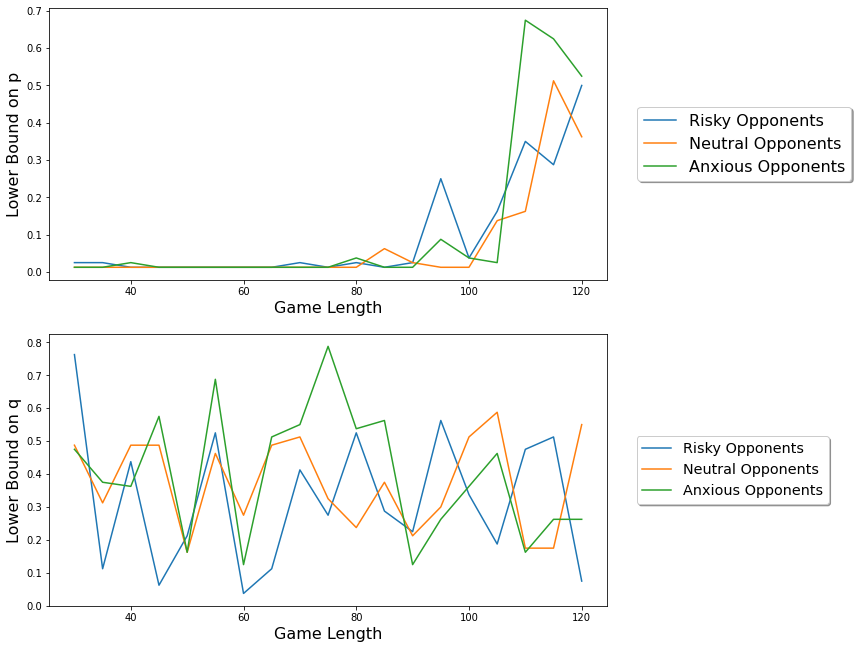

In [342]:
statsKnown2 = [[[],[]],[[],[]],[[],[]]]
for i in range(19):
        temp = optRisk(30 + i*5,0.2,0.8,1,0.9,1)
        statsKnown2[0][0].append(temp[0])
        statsKnown2[0][1].append(temp[1])
        temp = optRisk(30 + i*5,0.2,0.3,0.5,0.1,0.6)
        statsKnown2[1][0].append(temp[0])
        statsKnown2[1][1].append(temp[1])
        temp = optRisk(30 + i*5,0.2,0,0.2,0,0.2)
        statsKnown2[2][0].append(temp[0])
        statsKnown2[2][1].append(temp[1])

fig = plt.figure(figsize=(10,11))

ax1 = fig.add_subplot(211)
turns = np.arange(30, 125,5).tolist()

line1,=ax1.plot(turns,statsKnown2[0][0], label='Risky Opponents')
line2,=ax1.plot(turns,statsKnown2[1][0], label='Neutral Opponents')
line3,=ax1.plot(turns,statsKnown2[2][0], label='Anxious Opponents')

    
ax1.set_xlabel('Game Length',fontsize=16)
ax1.set_ylabel('Lower Bound on p',fontsize=16)
legend = ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, prop={"size":16})

ax2 = fig.add_subplot(212)

line1,=ax2.plot(turns,statsKnown2[0][1], label='Risky Opponents')
line2,=ax2.plot(turns,statsKnown2[1][1], label='Neutral Opponents')
line3,=ax2.plot(turns,statsKnown2[2][1], label='Anxious Opponents')
    
ax2.set_xlabel('Game Length',fontsize=16)
ax2.set_ylabel('Lower Bound on q',fontsize=16)
legend = ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')

plt.savefig('fig4a.png',bbox_inches='tight')
plt.show()

__Three Opponents:__

How will this change if we have three opponents instead? Does riskiness become more or less desirable? 

In [24]:
def optRisk2(gameLength = 30, width = 1/3,pLower = 0.6, pUpper = 0.8, qLower = 0.6, qUpper = 0.8):
    pL= 0.5 - width/2
    pU= 0.5 + width/2
    qL= 0.5 - width/2
    qU= 0.5 + width/2
    
    pl0 = stratPlayer(1,[pLower,pUpper],[qLower,qUpper])
    pl1 = stratPlayer(1,[pLower,pUpper],[qLower,qUpper])
    pl2 = stratPlayer(1,[pLower,pUpper],[qLower,qUpper])

    for k in range(5):
        
        pLOps = [pL- (0.5-width/2)*pow(2,-k-1),pL,pL+ (0.5-width/2)*pow(2,-k-1)]
        pUOps = [pU- (0.5-width/2)*pow(2,-k-1),pU,pU+(0.5-width/2)*pow(2,-k-1)]
        qRanges = []
        pWins = [0,0,0]
        for l in range(3):
            qL= 0.5 - width/2
            qU= 0.5 + width/2
            
            for i in range(5):
                wins = [0,0,0]
                qLOps = [qL- (0.5-width/2)*pow(2,-i-1),qL,qL+ (0.5-width/2)*pow(2,-i-1)]
                qUOps = [qU- (0.5-width/2)*pow(2,-i-1),qU,qU+(0.5-width/2)*pow(2,-i-1)]
        
                pl30 = stratPlayer(1,[pLOps[l],pUOps[l]],[qLOps[0],qUOps[0]])
                pl31 = stratPlayer(1,[pLOps[l],pUOps[l]],[qLOps[1],qUOps[1]])
                pl32 = stratPlayer(1,[pLOps[l],pUOps[l]],[qLOps[2],qUOps[2]])
        
                game0 = board([pl0,pl1,pl2,pl30])
                game1 = board([pl0,pl1,pl2,pl31])
                game2 = board([pl0,pl1,pl2,pl32])
        
                for j in range(1000):
                    game0.startGame(gameLength)
                    if pl30.money > max(pl0.money,pl1.money,pl2.money):
                        wins[0] += 1
                    game1.startGame(gameLength)
                    if pl31.money > max(pl0.money,pl1.money,pl2.money):
                        wins[1] += 1
                    game2.startGame(gameLength)
                    if pl32.money > max(pl0.money,pl1.money,pl2.money):
                        wins[2] += 1
        
                J = np.argmax(wins)
                qL= qLOps[J]
                qU= qUOps[J]
            qRanges.append([qL,qU])
            pWins[l] = max(wins)
        J = np.argmax(pWins)
        pL = pLOps[J]
        pU = pUOps[J]
        [qL,qU] = qRanges[J]
    return [pL , qL]

def optRisk2Int(gameLength = 30, width = 1/3,pLower = 0.6, pUpper = 0.8, qLower = 0.6, qUpper = 0.8):
    result = optRisk2(gameLength, width,pLower, pUpper, qLower, qUpper)
    print("[" + str(result[0]) + "," + str(result[0] + width) + "]" + "[" + str(result[1]) + "," + str(result[1]+width) + "]")

In [25]:
interact(optRisk2Int,     gameLength = (10,1000,10),
                    width     = (0,1,0.01),  
                    pLower = (0,1,0.01), 
                    pUpper = (0,1,0.01),
                    qLower = (0,1,0.01),
                    qUpper = (0,1,0.01));

interactive(children=(IntSlider(value=30, description='gameLength', max=1000, min=10, step=10), FloatSlider(va…

Once again we run our algorithm over games of different length ranging from 30 to 120, we find that four player games have a transition point at around games of length 55 turns. This is shown in the figures below, where we see that up until games of length 45 turns per player the lower bound on p is approximately 0 after 60 games per turn the lower bound on p is approximately 0.8. This transition doesn't appear to depend on the type of opponent.

Games of length shorter than 55 turns per player are unlikely to be particularly interesting. As such from this point onwards we shall be looking at games of length 80 turns per player. We will have to change our approach as our assumption that there is only one optimum value for q appears not to hold as in our figure below the optimum lower bound on q appears to be almost random.

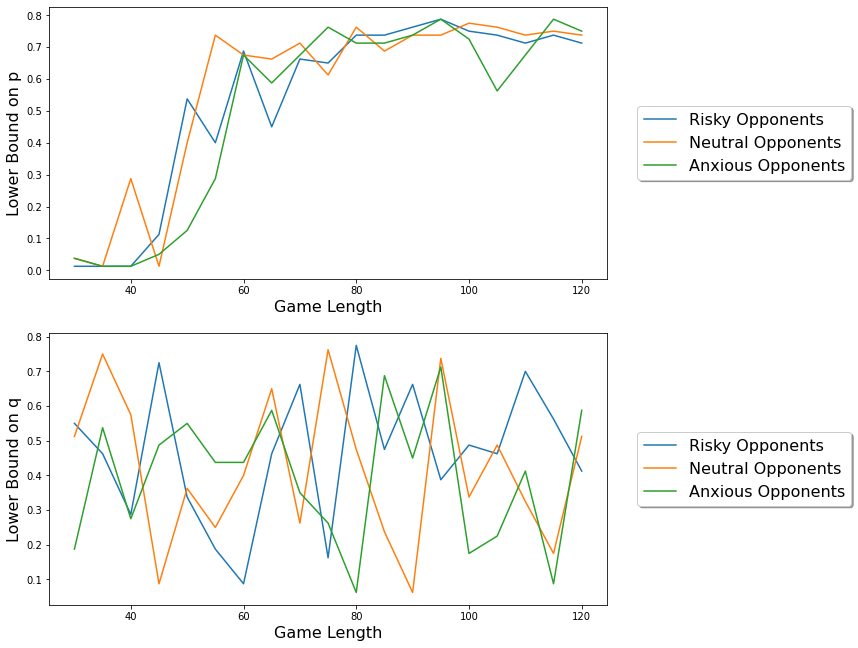

In [346]:
statsKnown = [[[],[]],[[],[]],[[],[]]]
for i in range(19):
        temp = optRisk2(30 + i*5,0.2,0.8,1,0.9,1)
        statsKnown[0][0].append(temp[0])
        statsKnown[0][1].append(temp[1])
        temp = optRisk2(30 + i*5,0.2,0.3,0.5,0.1,0.6)
        statsKnown[1][0].append(temp[0])
        statsKnown[1][1].append(temp[1])
        temp = optRisk2(30 + i*5,0.2,0,0.2,0,0.2)
        statsKnown[2][0].append(temp[0])
        statsKnown[2][1].append(temp[1])

fig = plt.figure(figsize=(10,11))

ax1 = fig.add_subplot(211)
turns = np.arange(30, 125,5).tolist()

line1,=ax1.plot(turns,statsKnown[0][0], label='Risky Opponents')
line2,=ax1.plot(turns,statsKnown[1][0], label='Neutral Opponents')
line3,=ax1.plot(turns,statsKnown[2][0], label='Anxious Opponents')

    
ax1.set_xlabel('Game Length',fontsize=16)
ax1.set_ylabel('Lower Bound on p',fontsize=16)
legend = ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large',prop={"size":16})

ax2 = fig.add_subplot(212)

line1,=ax2.plot(turns,statsKnown[0][1], label='Risky Opponents')
line2,=ax2.plot(turns,statsKnown[1][1], label='Neutral Opponents')
line3,=ax2.plot(turns,statsKnown[2][1], label='Anxious Opponents')
    
ax2.set_xlabel('Game Length',fontsize=16)
ax2.set_ylabel('Lower Bound on q',fontsize=16)
legend = ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large',prop={"size":16})

plt.savefig('fig4.png',bbox_inches='tight')
plt.show()

### Evolution Algorithm:

What if we don't know the riskiness of our opponent? Is there an ideal strategy regardless of your opponent? We shall now use an Evolution Algorithm to find out what are the so called "optimum" riskiness parameters.

An evolution algorithm works by creating 80 players and taking the parameters of the best 40 players and creating the next generation of players by mix and matching parameters from the best 40 opponents. For this project we shall perform 100 generations. An advantage of this algorithm is it doesn't have the limitation of our previous algorithm where we required the problem to have at most one optimum solution.

We have two factors to consider. We wish to optimise the number of games that we win while also minimising the number of times that we go bankrupt. We will consider two groups of players, Winners and Survivors. Winners will have the objective of coming first as often as possible while Survivors will have the goal of winning where possible while also keeping the number of bankruptcies low.

In [291]:
#Evolution Algorithm
def evolution(games = 25,length = 25,generations = 5):
    player = []
    #Creating random first gen
    for i in range(4*games):
        pWidth = random.uniform(0,1)
        pLow = random.uniform(0,1 - pWidth)
        qWidth = random.uniform(0,1)
        qLow = random.uniform(0,1 - qWidth)
        W = random.uniform(1,10)
        player.append(stratPlayer(W,[pLow,pLow + pWidth],[qLow,qLow + qWidth]))
    generation = [player.copy()]
    
    #Running for k generations
    for k in range(generations):
        
        #Creating games beginning by shuffling our players
        random.shuffle(player)
        game = []
        for i in range(games):
            game.append(board([player[4*i], player[4*i+1], player[4*i+2], player[4*i+3]]))
        wins = [0] * (4*games)    
        
        #Playing 1000 games per group of 4
        for i in range(1000):
            for j in range(games):
                game[j].startGame(length)
                
                #Recording who wins the game
                if player[4*j].money >= max(player[4*j + 1].money,player[4*j+2].money,player[4*j+3].money):
                    wins[4*j] += 1
                if player[4*j+1].money >= max(player[4*j].money,player[4*j+2].money,player[4*j+3].money):
                    wins[4*j+1] += 1
                if player[4*j+2].money >= max(player[4*j + 1].money,player[4*j].money,player[4*j+3].money):
                    wins[4*j+2] += 1
                if player[4*j+3].money >= max(player[4*j + 1].money,player[4*j+2].money,player[4*j].money):
                    wins[4*j+3] += 1
        #Selecting best 50% of population
        repro = []
        for i in range(2*games):
            best = np.argmax(wins)
            repro.append(stratPlayer(player[best].weight,[player[best].pLower,player[best].pUpper],[player[best].qLower,player[best].qUpper]))
            wins.pop(best)
            player.pop(best)
            
        #Randomly shuffle best population to decide on reproduction pairings
        random.shuffle(repro)
        nextGen = []
        for i in range(games):
            #Each pairing has two kids where the offspring's parameters lie within range of parent's parameters
            for j in range(2):
                #width = random.uniform(min(player[repro[2*i]].pUpper - player[repro[2*i]].pLower,player[repro[2*i+1]].pUpper - player[repro[2*i+1]].pLower),max(player[repro[2*i]].pUpper - player[repro[2*i]].pLower,player[repro[2*i+1]].pUpper - player[repro[2*i+1]].pLower))
                
                pRange = random.choice([[repro[2*i].pLower,repro[2*i].pUpper],[repro[2*i+1].pLower,repro[2*i+1].pUpper]])
                pNoise = np.random.normal(0,0.4,2)
                if pRange[0] + pNoise[0] >= 0 and pRange[1] + pNoise[1] <= 1 and pRange[0] + pNoise[0] <= pRange[1] + pNoise[1]:
                    pRange = [x + y for x,y in zip(pRange,pNoise)]
                
                qRange = random.choice([[repro[2*i].qLower,repro[2*i].qUpper],[repro[2*i+1].qLower,repro[2*i+1].qUpper]])
                qNoise = np.random.normal(0,0.4,2)
                if qRange[0] + qNoise[0] >= 0 and qRange[1] + qNoise[1] <= 1 and qRange[0] + qNoise[0] <= qRange[1] + qNoise[1]:
                    qRange = [x + y for x,y in zip(qRange,qNoise)]
                
                W = random.choice([repro[2*i].weight,repro[2*i+1].weight])
                wNoise = np.random.normal(0,0.5,1)
                if W + wNoise[0] >= 1 and W + wNoise[0] <= 10:
                    W =W + wNoise[0]
                
                nextGen.append(stratPlayer(W,pRange,qRange))
        player = nextGen.copy() + repro.copy()
        generation.append(repro.copy())
        print('Generation ' + str(k+1) + ' created')
    
    stats = []
    for gen in generation:
        genStats = [[], [], [], [], []]
        for player in gen:
            genStats[0].append(player.pLower)
            genStats[1].append(player.pUpper)
            genStats[2].append(player.qLower)
            genStats[3].append(player.qUpper)
            genStats[4].append(player.weight)
        stats.append(genStats)
    
    return stats

def evolution2(games = 25,length = 25,generations = 5):
    player = []
    #Creating random first gen
    for i in range(4*games):
        pWidth = random.uniform(0,1)
        pLow = random.uniform(0,1 - pWidth)
        qWidth = random.uniform(0,1)
        qLow = random.uniform(0,1 - qWidth)
        W = random.uniform(1,10)
        player.append(stratPlayer(W,[pLow,pLow + pWidth],[qLow,qLow + qWidth]))
    generation = [player.copy()]
    
    #Running for k generations
    for k in range(generations):
        
        #Creating games beginning by shuffling our players
        random.shuffle(player)
        game = []
        for i in range(games):
            game.append(board([player[4*i], player[4*i+1], player[4*i+2], player[4*i+3]]))
        wins = [0] * (4*games)
        broke = [1] * (4*games)
        
        #Playing 1000 games per group of 4
        for i in range(1000):
            for j in range(games):
                game[j].startGame(length)
                
                #Recording who wins the game
                if player[4*j].money >= max(player[4*j + 1].money,player[4*j+2].money,player[4*j+3].money):
                    wins[4*j] += 1
                if player[4*j+1].money >= max(player[4*j].money,player[4*j+2].money,player[4*j+3].money):
                    wins[4*j+1] += 1
                if player[4*j+2].money >= max(player[4*j + 1].money,player[4*j].money,player[4*j+3].money):
                    wins[4*j+2] += 1
                if player[4*j+3].money >= max(player[4*j + 1].money,player[4*j+2].money,player[4*j].money):
                    wins[4*j+3] += 1
                
                #recording bankruptcy
                if player[4*j].money == -1:
                    broke[4*j] += 1
                if player[4*j+1].money == -1:
                    broke[4*j+1] += 1
                if player[4*j+2].money == -1:
                    broke[4*j+2] += 1
                if player[4*j+3].money == -1:
                    broke[4*j+3] += 1
        #Selecting best 50% of population
        repro = []
        res = [win / loss for win, loss in zip(wins, broke)]
        for i in range(2*games):
            best = np.argmax(res)
            repro.append(stratPlayer(player[best].weight,[player[best].pLower,player[best].pUpper],[player[best].qLower,player[best].qUpper]))
            res.pop(best)
            player.pop(best)
            
        #Randomly shuffle best population to decide on reproduction pairings
        random.shuffle(repro)
        nextGen = []
        for i in range(games):
            #Each pairing has two kids where the offspring's parameters lie within range of parent's parameters
            for j in range(2):
                #width = random.uniform(min(player[repro[2*i]].pUpper - player[repro[2*i]].pLower,player[repro[2*i+1]].pUpper - player[repro[2*i+1]].pLower),max(player[repro[2*i]].pUpper - player[repro[2*i]].pLower,player[repro[2*i+1]].pUpper - player[repro[2*i+1]].pLower))
                
                pRange = random.choice([[repro[2*i].pLower,repro[2*i].pUpper],[repro[2*i+1].pLower,repro[2*i+1].pUpper]])
                pNoise = np.random.normal(0,0.4,2)
                if pRange[0] + pNoise[0] >= 0 and pRange[1] + pNoise[1] <= 1 and pRange[0] + pNoise[0] <= pRange[1] + pNoise[1]:
                    pRange = [x + y for x,y in zip(pRange,pNoise)]
                
                qRange = random.choice([[repro[2*i].qLower,repro[2*i].qUpper],[repro[2*i+1].qLower,repro[2*i+1].qUpper]])
                qNoise = np.random.normal(0,0.4,2)
                if qRange[0] + qNoise[0] >= 0 and qRange[1] + qNoise[1] <= 1 and qRange[0] + qNoise[0] <= qRange[1] + qNoise[1]:
                    qRange = [x + y for x,y in zip(qRange,qNoise)]
                
                W = random.choice([repro[2*i].weight,repro[2*i+1].weight])
                wNoise = np.random.normal(0,0.5,1)
                if W + wNoise[0] >= 1 and W + wNoise[0] <= 10:
                    W = W + wNoise[0]
                
                nextGen.append(stratPlayer(W,pRange,qRange))
        player = nextGen.copy() + repro.copy()
        generation.append(repro.copy())
        print('Generation ' + str(k+1) + ' created')
    
    stats = []
    for gen in generation:
        genStats = [[], [], [], [], []]
        for player in gen:
            genStats[0].append(player.pLower)
            genStats[1].append(player.pUpper)
            genStats[2].append(player.qLower)
            genStats[3].append(player.qUpper)
            genStats[4].append(player.weight)
        stats.append(genStats)
    
    return stats


#Function to plot results
def plot(generations,i,ver):
    stats = generations[i]
    #ax = fig.add_subplot(321, projection='3d'
    pMedian = [(pLow + pUp)/2 for pLow,pUp in zip(stats[0],stats[1])]
    qMedian = [(qLow + qUp)/2 for qLow,qUp in zip(stats[2],stats[3])]
    pWidth = [pUp - pLow for pLow,pUp in zip(stats[0],stats[1])]
    qWidth = [qUp - qLow for qLow,qUp in zip(stats[2],stats[3])]
    
    fig = plt.figure(figsize=(10,17))
    ax1 = fig.add_subplot(321)
    
    ax1.scatter(pMedian,qMedian)
    
    ax1.set_xlabel('Median p Value', fontsize=16)
    ax1.set_ylabel('Median q Value', fontsize=16)
    #ax.set_zlabel('Z Label')
    
    ax2 = fig.add_subplot(322)
    ax2.scatter(pMedian,stats[4])
    
    ax2.set_xlabel('Median p Value', fontsize=16)
    ax2.set_ylabel('Weighting on Money', fontsize=16)
    
    ax2 = fig.add_subplot(323)
    ax2.scatter(pMedian,pWidth)
    
    ax2.set_xlabel('Median p Value', fontsize=16)
    ax2.set_ylabel('Range of Riskiness p', fontsize=16)
                   
    ax2 = fig.add_subplot(324)
    ax2.scatter(pWidth,qWidth)
    
    ax2.set_xlabel('Range of Riskiness p', fontsize=16)
    ax2.set_ylabel('Range of Riskiness q', fontsize=16)
    
    plt.savefig('fig5-' + str(ver) + '.png',bbox_inches='tight')
    plt.show()
    

In [ ]:
stats1 = evolution(20,80,100)
stats2 = evolution2(20,80,100)

Below you will see scatter plots where each point represents one of the final 40 players at the end of the 100 generations for our Winners. Looking at the top right-hand figure, we can see that a high riskiness is beneficial when buying streets, p, and our weighting on money doesn't seem to have a specific optimum value. Repeated runs of our evolution algorithm give the same conclusion that our weighting on money should be in the range 1-5. It would appear that the probability of buying a house, q, does not make any significant difference to our chances of winning

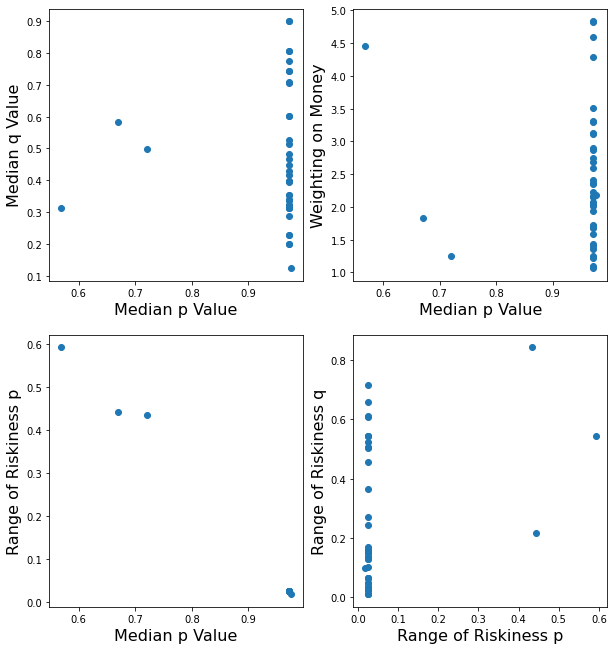

In [292]:
plot(stats1,-1,0)

Now we can see the results of our evolution algorithm for Survivors in the scatter plots below. This time a low probability of buying a street, p, of no more than 0.1 is beneficial to avoiding bankruptcy. To complement this, our players now have a high value on money with a weighting in the range 5.5-10 on their money. Once again the probability of buying a house, q, does not appear to matter for our Survivors.

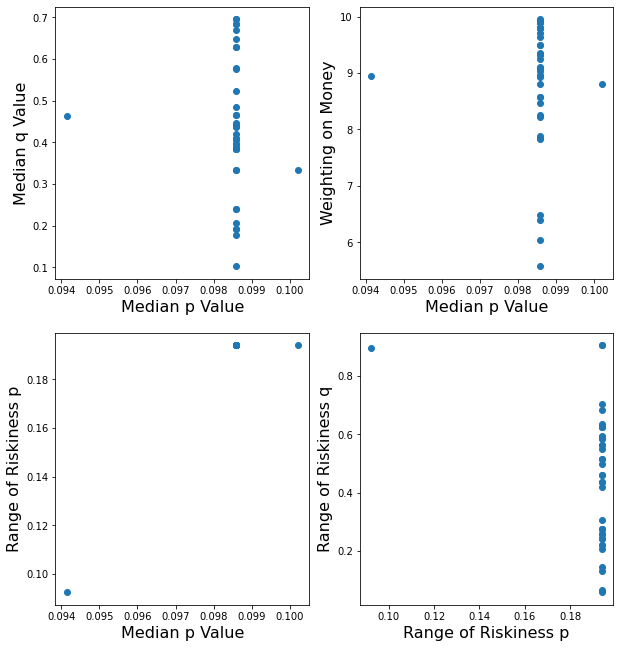

In [293]:
plot(stats2,-1,1)

So how do these two objectives compare to each other? Below we see a stacked bar plot showing the proportion of games where one of the players with a given strategy won, went bankrupt, or neither. What we see is that the appropriately named survivors have a very low probability of going bankrupt but only win 4.25\% of the games they play. Meanwhile, our Winners will win the game with probability 43.19\% but this increase in winning comes with an increased probability that they will go bankrupt.

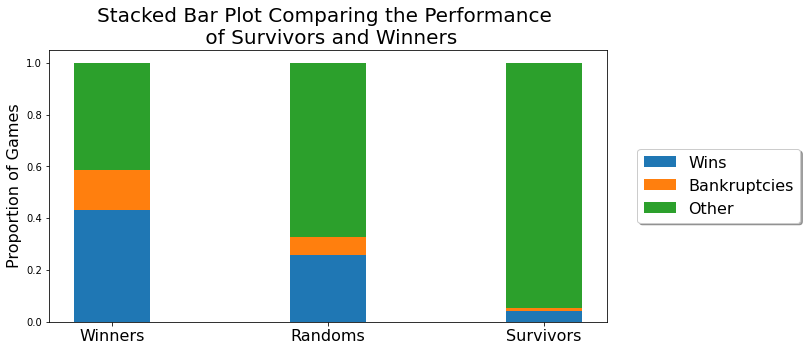

In [339]:
championsW = []
championsB = []
championsR = []
for i in range(10):
    num = random.randint(0,len(stats1[-1][0])-1)
    championsW.append(stratPlayer(stats1[-1][4][num],[stats1[-1][0][num],stats1[-1][1][num]],[stats1[-1][2][num],stats1[-1][3][num]]))
    num = random.randint(0,len(stats2[-1][0])-1)
    championsB.append(stratPlayer(stats2[-1][4][num],[stats2[-1][0][num],stats2[-1][1][num]],[stats2[-1][2][num],stats2[-1][3][num]]))
    
    pWidth = random.uniform(0,1)
    pLow = random.uniform(0,1 - pWidth)
    qWidth = random.uniform(0,1)
    qLow = random.uniform(0,1 - qWidth)
    W = random.uniform(1,10)
    championsR.append(stratPlayer(W,[pLow,pLow + pWidth],[qLow,qLow + qWidth]))
        
winsW = 0
winsB = 0
winsR = 0
brokeW = 0
brokeB = 0
brokeR = 0

for j in range(10):
    players = [championsW[j]]
    for i in range(3):
        pWidth = random.uniform(0,1)
        pLow = random.uniform(0,1 - pWidth)
        qWidth = random.uniform(0,1)
        qLow = random.uniform(0,1 - qWidth)
        W = random.uniform(1,10)
        players.append(stratPlayer(W,[pLow,pLow + pWidth],[qLow,qLow + qWidth]))
    game = board(players)
    for i in range(1000):
        game.startGame(100)
        if players[0].money >= max(players[1].money,players[2].money,players[3].money):
            winsW += 1
        if players[0].money == -1:
            brokeW += 1
    
    players = [championsB[j]]
    for i in range(3):
        pWidth = random.uniform(0,1)
        pLow = random.uniform(0,1 - pWidth)
        qWidth = random.uniform(0,1)
        qLow = random.uniform(0,1 - qWidth)
        W = random.uniform(1,10)
        players.append(stratPlayer(W,[pLow,pLow + pWidth],[qLow,qLow + qWidth]))
    game = board(players)
    for i in range(1000):
        game.startGame(100)
        if players[0].money >= max(players[1].money,players[2].money,players[3].money):
            winsB += 1
        if players[0].money == -1:
            brokeB += 1
            
    players = [championsR[j]]
    for i in range(3):
        pWidth = random.uniform(0,1)
        pLow = random.uniform(0,1 - pWidth)
        qWidth = random.uniform(0,1)
        qLow = random.uniform(0,1 - qWidth)
        W = random.uniform(1,10)
        players.append(stratPlayer(W,[pLow,pLow + pWidth],[qLow,qLow + qWidth]))
    game = board(players)
    for i in range(1000):
        game.startGame(100)
        if players[0].money >= max(players[1].money,players[2].money,players[3].money):
            winsR += 1
        if players[0].money == -1:
            brokeR += 1

labels = ['Winners', 'Randoms' ,'Survivors']
wins = [winsW/10000, winsR/10000 ,winsB/10000]
survivals = [(10000 - winsW - brokeW)/10000, (10000 - winsR - brokeR)/10000, (10000 - winsB - brokeB) / 10000]
busts = [brokeW/10000, brokeR/10000, brokeB/10000]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(10,5))

plt.xticks(fontsize=16)

ax.bar(labels, wins, width, label='Wins')
ax.bar(labels, busts, width, bottom=wins,label='Bankruptcies')
ax.bar(labels, survivals, width, bottom=[busts[0] + wins[0],busts[1] + wins[1], busts[2] + wins[2]],label='Other')


ax.set_ylabel('Proportion of Games', fontsize=16)
ax.set_title('Stacked Bar Plot Comparing the Performance \n of Survivors and Winners', fontsize=20)
ax.legend(prop={"size":16})

plt.savefig('fig6.png',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10,5))

plt.xticks(fontsize=16)

ax.bar(labels, wins, width, label='Wins')
ax.bar(labels, busts, width, bottom=wins,label='Bankruptcies')
ax.bar(labels, survivals, width, bottom=[busts[0] + wins[0],busts[1] + wins[1], busts[2] + wins[2]],label='Other')


ax.set_ylabel('Proportion of Games', fontsize=16)
ax.set_title('Stacked Bar Plot Comparing the Performance \n of Survivors and Winners', fontsize=20)
ax.legend(prop={"size":16},bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True)

plt.savefig('fig6.png',bbox_inches='tight')
plt.show()

What we have found is that the two objectives of surviving and winning oppose one another. To be in with the chance of winning you need to have a high risk strategy but with that you also burden yourself with an increased risk of bankruptcy. So in a game of monopoly you have to ask yourself how big a risk are you willing to take in order to win? At what point is the risk of bankruptcy too high to make the risk worthwhile? This is a decision only you can make. So take on board what we have found and choose how risky you wish to be in your next game of Monopoly wisely, as what we have shown is that the game of Monopoly does not rely on just chance alone.